In [322]:
import numpy as np
import pandas as pd
from keras.utils import np_utils
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import seaborn as sns; sns.set()
from sklearn.metrics import roc_curve
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix,accuracy_score, precision_score, recall_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.cluster import KMeans
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from keras.models import Sequential
from keras.layers import Dense
from sklearn import tree

In [254]:
#Read the integrated data from R
data = pd.read_csv(r"C:\Users\krith\Documents\Courses\Spring_2023_Courses\Applied ML\project.csv")
data.head()

,Unnamed: 0,Cct7,Rest,Rnf8,Lsm8,Tomm20,Capns1,Mdh1,Rdh14,Ipo13,...,Slc35b1,Uqcrb,Cxcl12,Xpnpep1,Vkorc1l1,Pigs,Sfpq,Gps1,Btbd1,Sec23b
0,LNHEV_pool2.4_S100,1.964845,-1.345629,-1.148360,-1.308958,-0.658154,-0.292898,-0.787920,-1.103713,-1.081386,...,1.544329,-0.865758,-1.092737,-0.803328,4.120422,-1.325533,2.640483,-1.011700,-1.096811,-0.916358
1,LNHEV_pool2.5_S101,0.218246,3.590502,3.911285,3.750686,-0.236709,-0.288136,2.047932,-1.103713,-1.081386,...,0.046808,0.352407,-1.092737,-0.262802,-0.939222,-1.325533,-0.059719,-1.012299,-1.096811,-0.918411
2,LNHEV_pool2.6_S102,2.135930,-1.382633,-1.148360,-1.308958,-0.658713,-0.582488,-0.878131,-1.103713,-1.081386,...,2.556333,-0.873227,0.670840,-0.930471,-0.939222,-1.325533,-0.728765,-1.012459,3.962833,-0.918964
3,LNHEV_pool2.7_S103,-1.216504,3.590502,3.911285,-1.308958,0.364668,0.680890,-0.878092,-1.103713,-1.081386,...,0.838900,-0.493654,3.966908,-0.930379,-0.939222,-1.325533,-0.728702,-1.012407,-1.096811,1.846994
4,LNHEV_pool2.8_S104,0.463721,-1.445573,-1.148360,-1.308958,-0.659572,0.890238,-0.879006,-1.103713,-1.081386,...,0.793516,-0.579820,-1.092737,1.798850,-0.939222,3.734111,-0.730186,0.971054,-1.096811,-0.923078


In [377]:
#subset the row indices to get localization and use it as target variable
labels = data.iloc[:,0:1]
print(labels.shape)
print(labels)
#Extract row indices and label encode them
labels['locus'] = labels['Unnamed: 0'].str.split('_').str[0]
#print(labels.head())
labels.drop('Unnamed: 0', axis=1, inplace=True)

(1233, 1)
                Unnamed: 0
0       LNHEV_pool2.4_S100
1       LNHEV_pool2.5_S101
2       LNHEV_pool2.6_S102
3       LNHEV_pool2.7_S103
4       LNHEV_pool2.8_S104
...                    ...
1228   BrainEC_m1_AY_Y3_P6
1229   BrainEC_m1_AY_Y3_F6
1230  BrainEC_m1_AY_Y3_O18
1231   BrainEC_m1_AY_Y3_P1
1232   BrainEC_m1_AY_Y3_O5

[1233 rows x 1 columns]


In [378]:
#Create unique labels for class names to be used while plotting decision tree
uq = labels.locus.unique()
print(uq)
#ccreate a dataframe of labels column to be used as target variable
label_trans = pd.DataFrame(labels)

['LNHEV' 'HEC' 'BrainEC']


In [280]:
#subset the data 1st column onwards for features
df = data.iloc[:,1:]
df.head()
x = df
print(x)

          Cct7      Rest      Rnf8      Lsm8    Tomm20    Capns1      Mdh1  \
0     1.964845 -1.345629 -1.148360 -1.308958 -0.658154 -0.292898 -0.787920   
1     0.218246  3.590502  3.911285  3.750686 -0.236709 -0.288136  2.047932   
2     2.135930 -1.382633 -1.148360 -1.308958 -0.658713 -0.582488 -0.878131   
3    -1.216504  3.590502  3.911285 -1.308958  0.364668  0.680890 -0.878092   
4     0.463721 -1.445573 -1.148360 -1.308958 -0.659572  0.890238 -0.879006   
...        ...       ...       ...       ...       ...       ...       ...   
1228 -1.921161 -0.772644 -0.389791 -0.874389 -0.830039 -0.942729 -1.398593   
1229  2.399333 -0.772644 -0.389791 -0.874389 -0.830039 -0.942729  2.921901   
1230  2.399333  3.547850 -0.389791  0.779543 -0.830039 -0.942729 -1.398593   
1231 -1.921161 -0.772644 -0.389791 -0.874389 -0.830039  3.377765 -1.398593   
1232  2.399333 -0.772644 -0.389791  3.446105 -0.830039 -0.942729 -1.398593   

         Rdh14     Ipo13     Stx12  ...   Slc35b1     Uqcrb    

In [379]:
#Use the train_test_split function to split the data into training and validation sets
x_train, x_val, y_train, y_val = train_test_split(x, label_trans, test_size = 0.2, random_state=108)

In [380]:
#Polynomial SVM
model = svm.SVC()
# defining parameter range
param_grid = {'C': [0.01,0.1,1], 
              'gamma': ['auto'],
              'kernel': ['poly','rbf'],
             'degree': [3]}

grid = GridSearchCV(model, param_grid, refit = True, verbose = 1,cv=3)

# fitting the model for grid search
grid_search=grid.fit(x_train, y_train.values.ravel())
print(grid_search.best_params_)
train_accu = grid_search.best_score_*100
print("Accuracy for training dataset with tuning is : {:.2f}%".format(train_accu))

#testing the model
y_pred = grid.predict(x_val)
test_accuracy=accuracy_score(y_val,y_pred)*100
print("Accuracy for testing dataset with tuning is : {:.2f}%".format(test_accuracy))

Fitting 3 folds for each of 6 candidates, totalling 18 fits
{'C': 1, 'degree': 3, 'gamma': 'auto', 'kernel': 'rbf'}
Accuracy for training dataset with tuning is : 86.82%
Accuracy for testing dataset with tuning is : 85.43%


In [381]:
#Precision & Recall of SVM Model
precision_svm = precision_score(y_val,y_pred, average='weighted')*100
print("Precision of the SVM model with tuning is : {:.2f}%".format(precision_svm))
recall_svm = recall_score(y_val,y_pred, average='weighted')*100
print("Recall of the SVM model with tuning is : {:.2f}%".format(recall_svm))

Precision of the SVM model with tuning is : 73.55%
Recall of the SVM model with tuning is : 85.43%


['HEC', 'BrainEC']
['BrainEC', 'HEC', 'LNHEV']
['BrainEC' 'HEC' 'LNHEV']


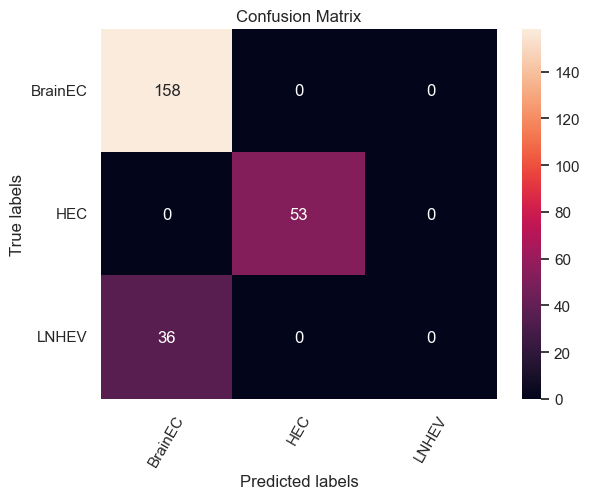

In [383]:
#Check and sort the predicted labels
pred_label = list(set((y_pred)))
print(pred_label)
pred_label.append('LNHEV')
pred_label.sort()
print(pred_label)
true_label = np.unique(y_val)
true_label.sort()
print(true_label)
# Compute confusion matrix
cm = confusion_matrix(y_val, y_pred)
# Plot confusion matrix

ax = sns.heatmap(cm, annot=True, fmt="d", cmap="rocket")
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(pred_label, rotation=60); 
ax.yaxis.set_ticklabels(true_label, rotation=0);

In [324]:
# Create Decision Tree classifer object
#Train decision tree
clf = DecisionTreeClassifier()
param = {'max_depth': [3,4,5],
        'criterion':['gini', 'entropy']}
grid_dtree = GridSearchCV(clf, param, refit = True, verbose = 1,cv=3)

# fitting the model for grid search
model_dtree = grid_dtree.fit(x_train, y_train)
print('The best estimator is ',model_dtree.best_estimator_)
print('The best parameter is', model_dtree.best_params_)

#testing the model
y_pred_dtree = grid_dtree.predict(x_val)
accuracy = accuracy_score(y_val,y_pred_dtree)*100
print("Accuracy of the decision tree model with tuning is : {:.2f}%".format(accuracy))

Fitting 3 folds for each of 6 candidates, totalling 18 fits
The best estimator is  DecisionTreeClassifier(max_depth=4)
The best parameter is {'criterion': 'gini', 'max_depth': 4}
Accuracy of the decision tree model with tuning is : 95.95%


In [325]:
#Precision & Recall of Decision Tree Model
precision_dtree = precision_score(y_val,y_pred_dtree, average='weighted')*100
print("Precision of the decision tree model with tuning is : {:.2f}%".format(precision_dtree))
recall_dtree = recall_score(y_val,y_pred_dtree, average='weighted')*100
print("Recall of the decision tree model with tuning is : {:.2f}%".format(recall_dtree))

Precision of the decision tree model with tuning is : 96.33%
Recall of the decision tree model with tuning is : 95.95%


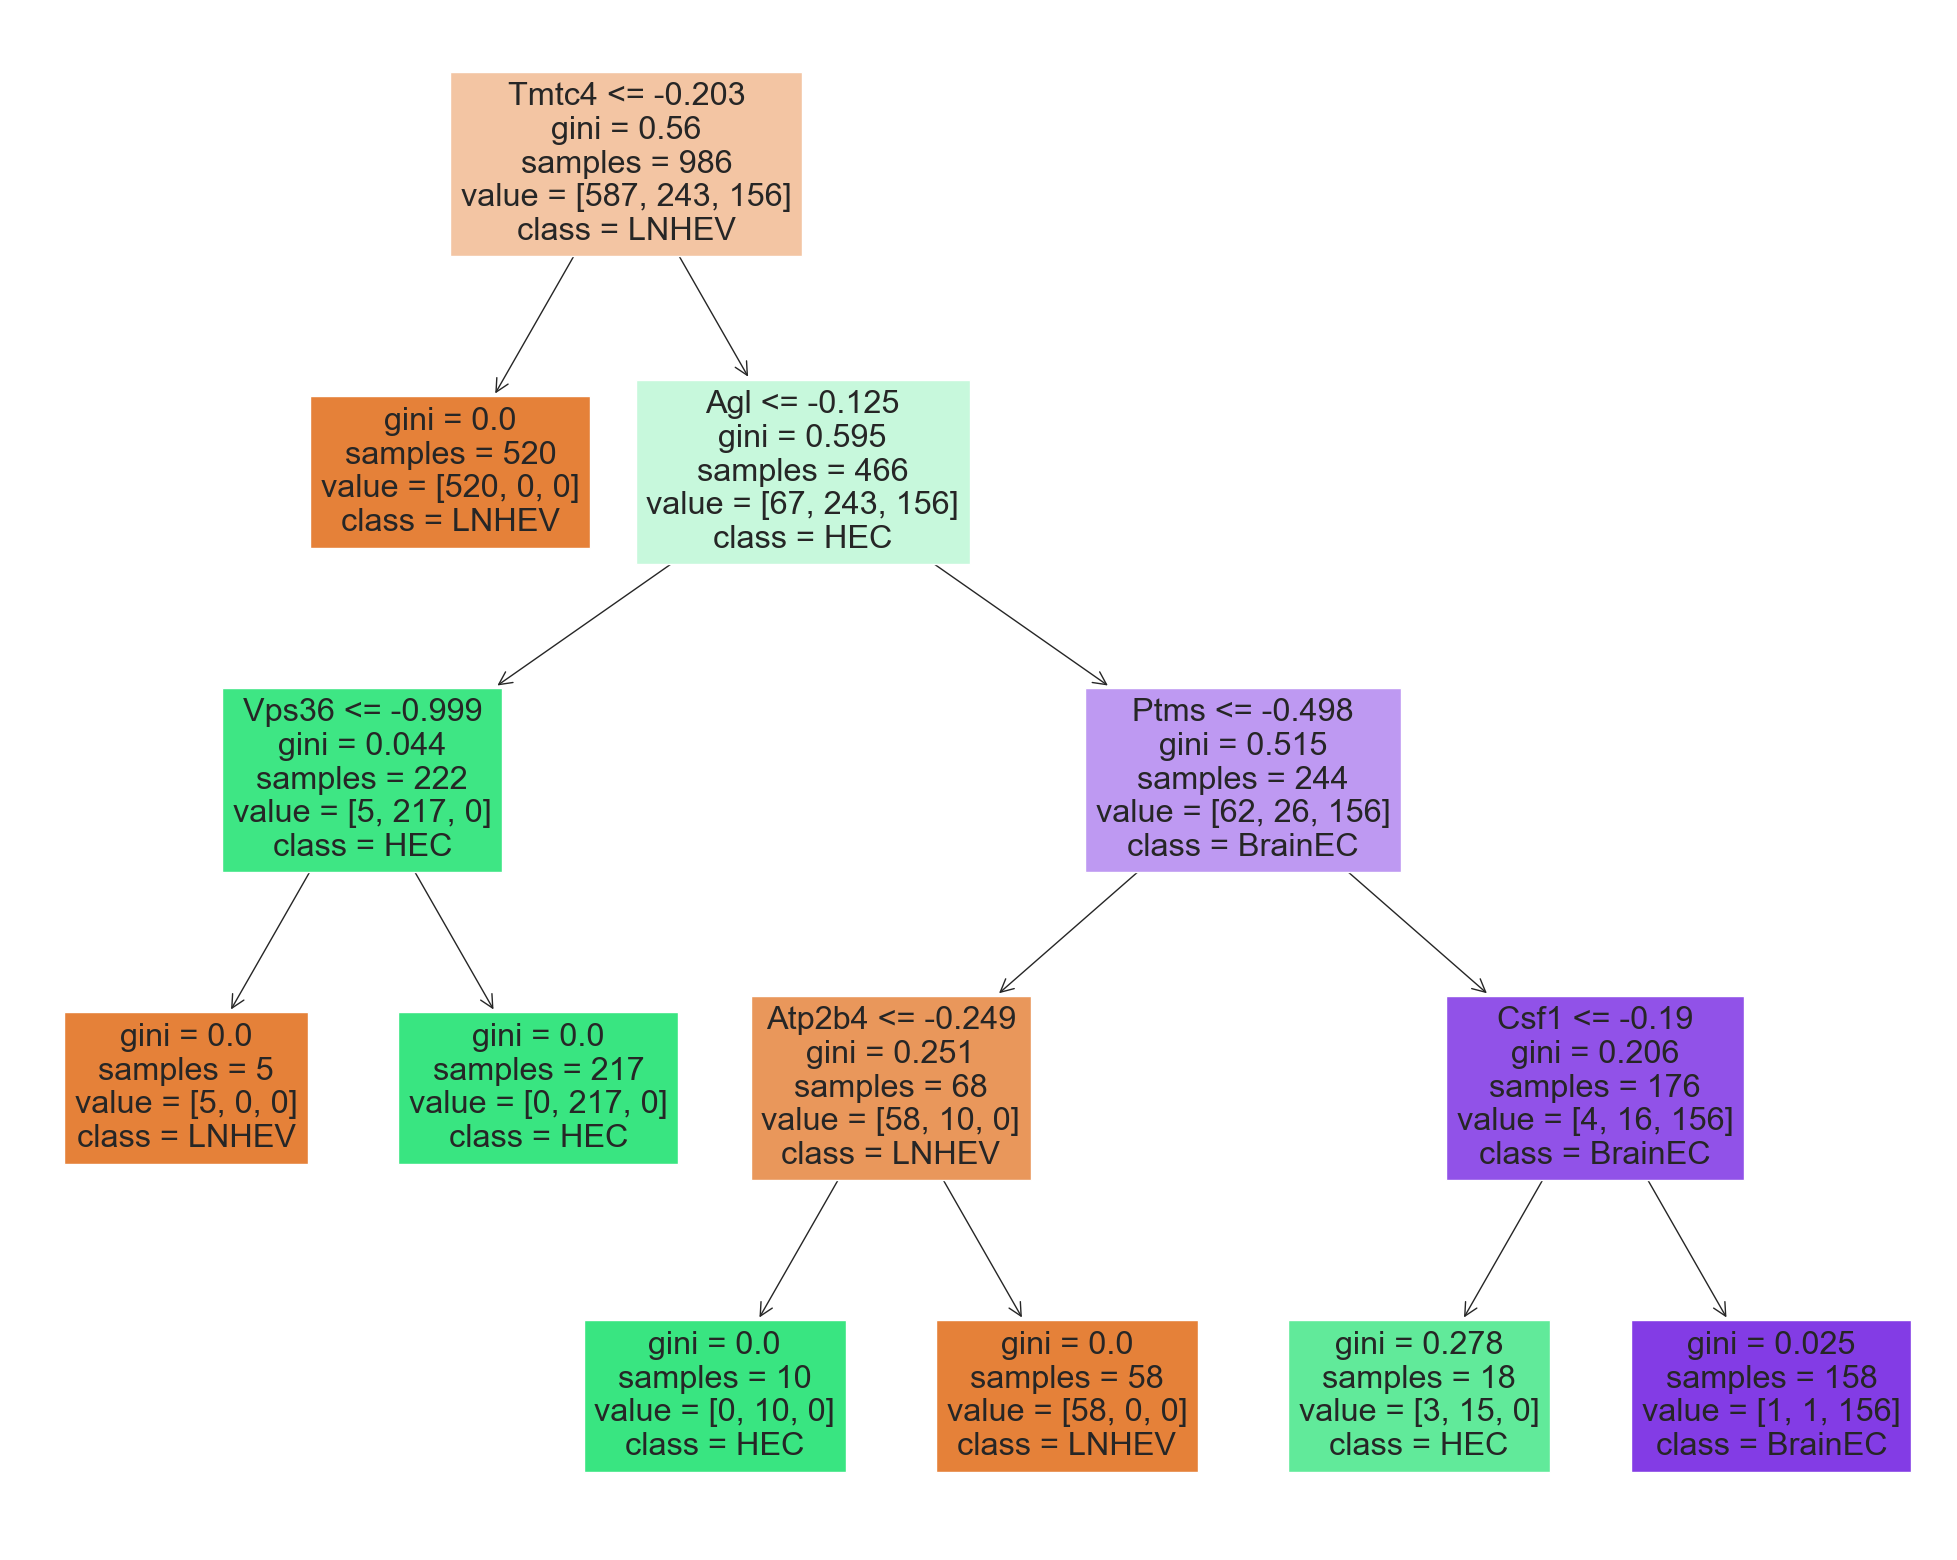

In [343]:
##Plot the best estimator for decision tree
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(model_dtree.best_estimator_, 
                   feature_names=df.columns,  
                   class_names=uq,
                   filled=True)

['HEC', 'LNHEV', 'BrainEC']


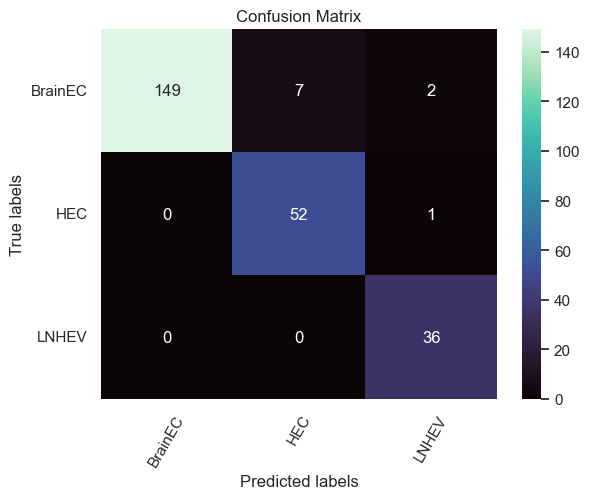

In [344]:
#Check and sort the predicted labels
predtree_label = list(set((y_pred_dtree)))
print(predtree_label)
predtree_label.sort()
# Compute confusion matrix
cm = confusion_matrix(y_val, y_pred_dtree)

# Plot confusion matrix
ax = sns.heatmap(cm, annot=True, fmt="d", cmap="mako")
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(predtree_label, rotation=60); 
ax.yaxis.set_ticklabels(true_label, rotation=0);

Fitting 3 folds for each of 16 candidates, totalling 48 fits
The best parameter is {'criterion': 'gini', 'max_depth': 5, 'max_features': 'sqrt', 'n_estimators': 100}
Zfhx2       0.019031
Gfod1       0.013493
Sh3bgrl2    0.012186
Mr1         0.011648
Nol4l       0.011582
              ...   
Hsd17b12    0.000000
Sel1l       0.000000
Grk2        0.000000
Morc3       0.000000
Sec23b      0.000000
Length: 5000, dtype: float64


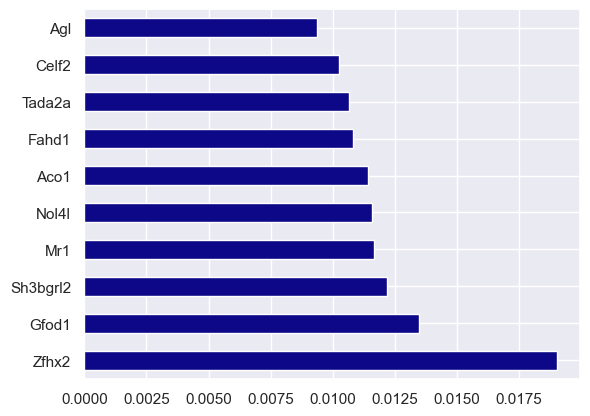

In [302]:
#Create Random Forest classifier
rf = RandomForestClassifier()

#Define grid parameters
grid_param = {'n_estimators': [100,200],
             'max_depth' : [5,10],
             'max_features': ['sqrt', 'log2'],
             'criterion': ['gini','entropy']}
#Doing grid search
grid_rf = GridSearchCV(rf, grid_param, cv=3, verbose=1, refit=True)

#Fitting the model
model_rf = grid_rf.fit(x_train, y_train.values.ravel())
print('The best parameter is', model_rf.best_params_)

best_estimator = grid_rf.best_estimator_
# Get the feature importances
feature_importances = pd.Series(best_estimator.feature_importances_, index=df.columns)
# Rank the features by importance
ranked_features = feature_importances.sort_values(ascending=False)
print(ranked_features)

feature_importances.nlargest(10).plot(kind='barh', cmap='plasma')
plt.show()

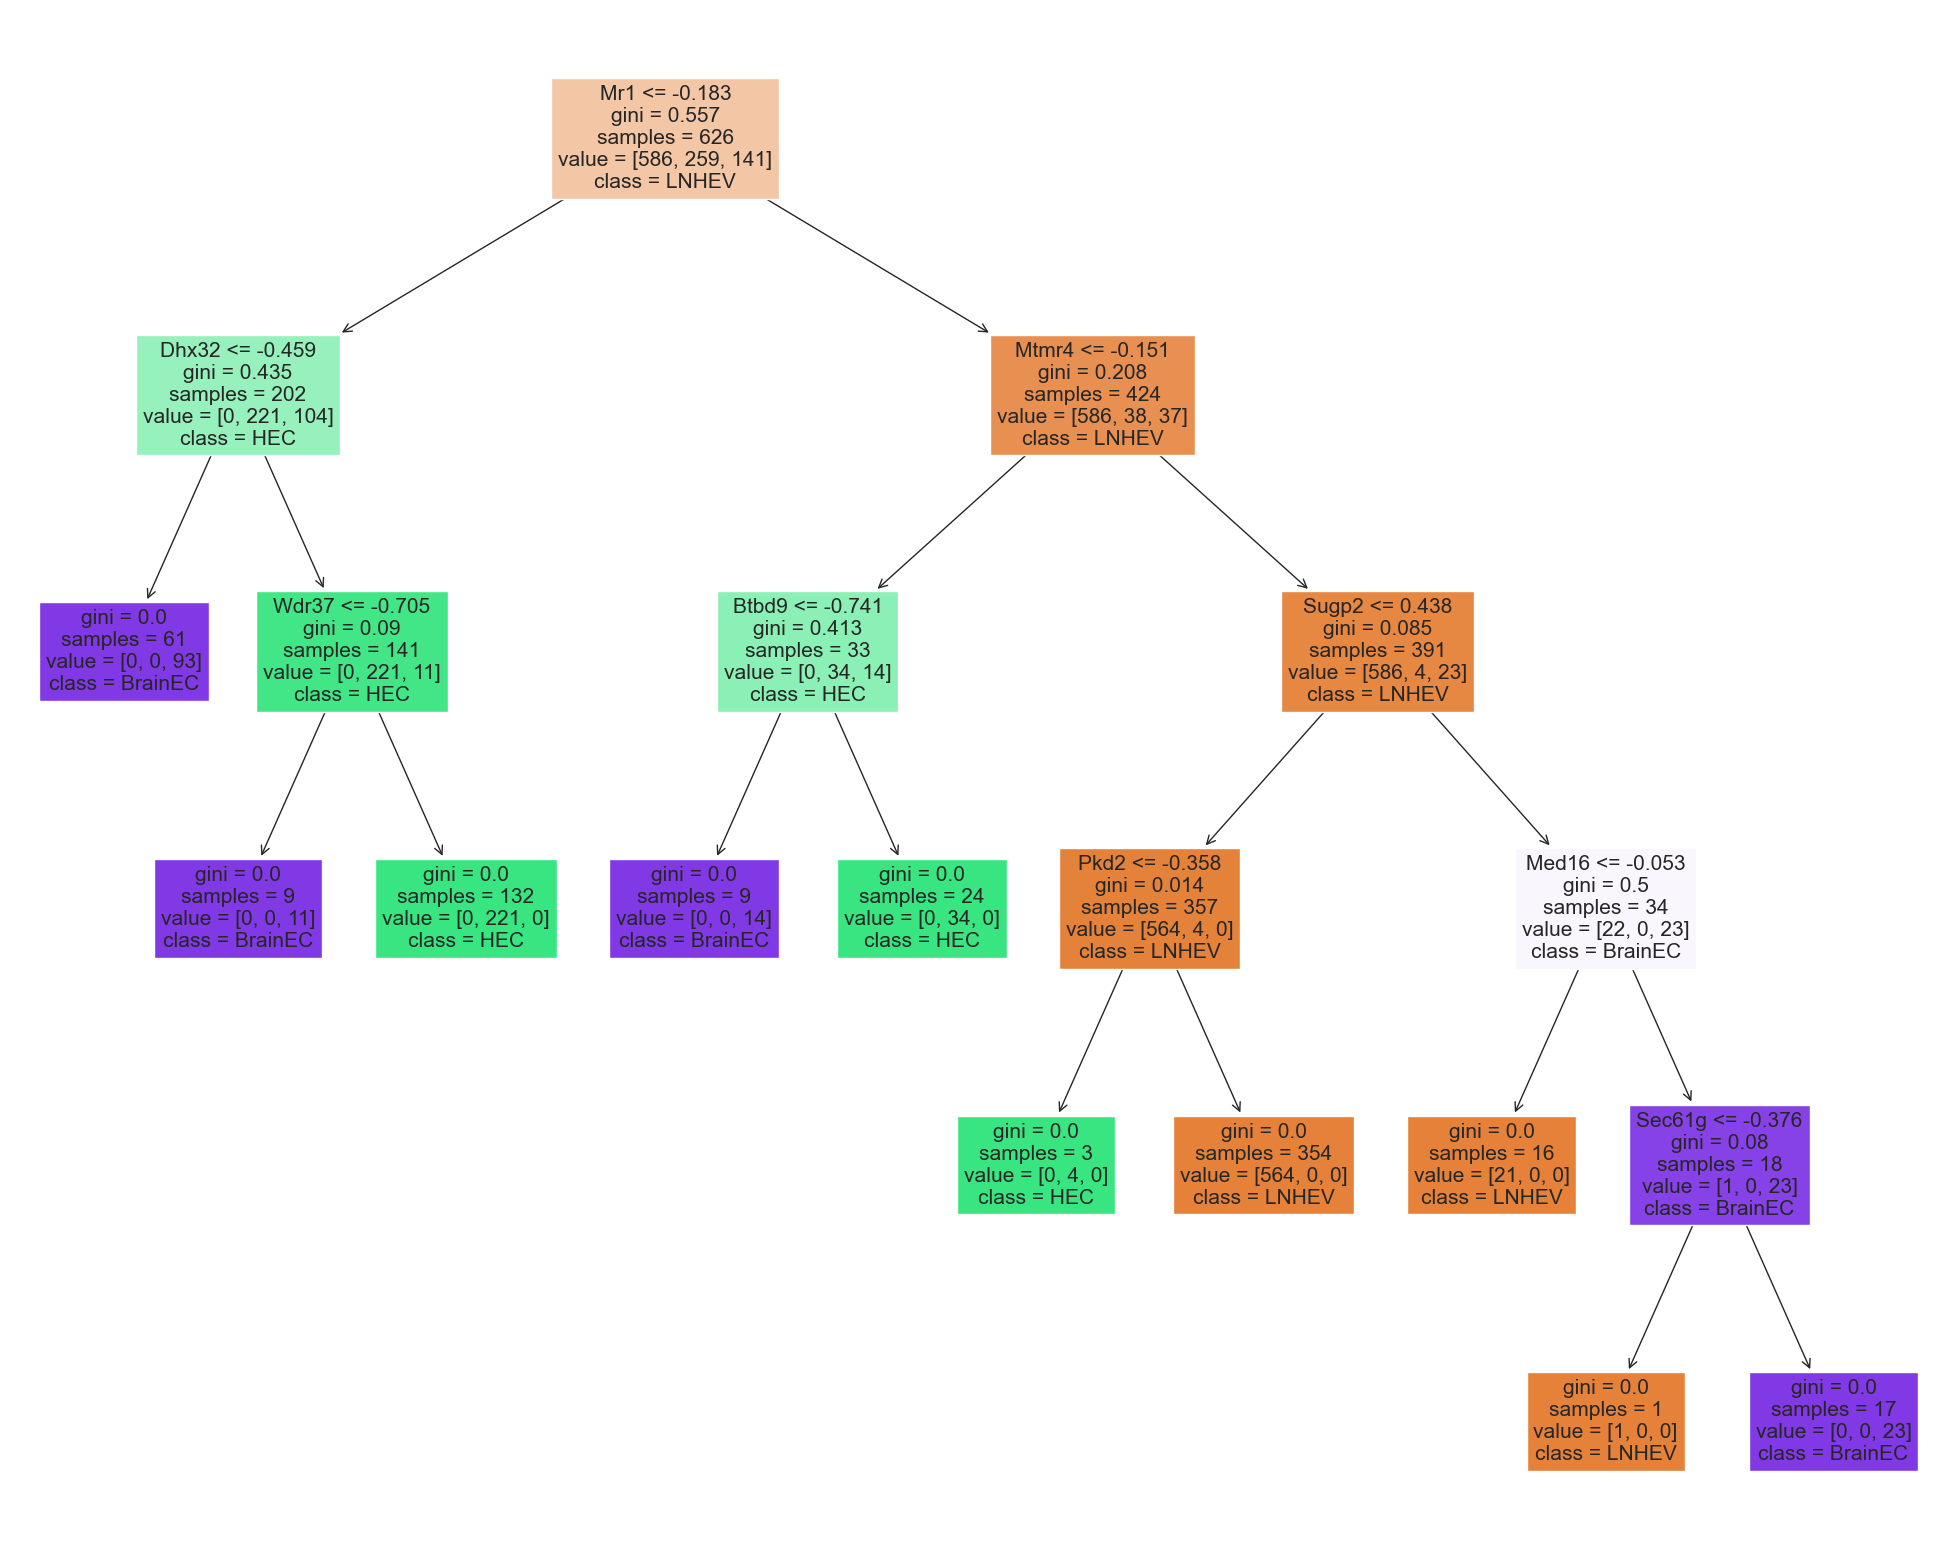

In [355]:
##Plot a tree from the forest
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(grid_rf.best_estimator_.estimators_[3], 
                   feature_names=df.columns,  
                   class_names=uq,
                   filled=True)

In [303]:
#Testing the model
y_pred_rf = grid_rf.predict(x_val)
accuracy_rf = accuracy_score(y_val,y_pred_rf)*100
print("Accuracy of the random forest model with tuning is : {:.2f}%".format(accuracy_rf))

#Precision & Recall of Random Forest Model
precision_rf = precision_score(y_val,y_pred_rf, average='weighted')*100
print("Precision of the random forest model with tuning is : {:.2f}%".format(precision_rf))

recall_rf = recall_score(y_val,y_pred_rf, average='weighted')*100
print("Recall of the random forest model with tuning is : {:.2f}%".format(recall_rf))

Accuracy of the random forest model with tuning is : 100.00%
Precision of the random forest model with tuning is : 100.00%
Recall of the random forest model with tuning is : 100.00%


['HEC', 'LNHEV', 'BrainEC']


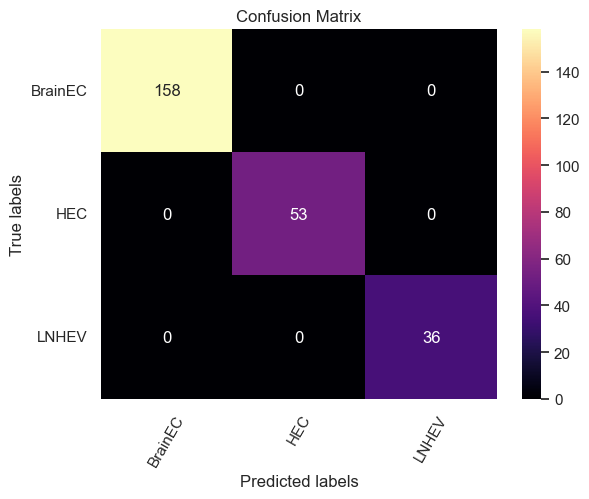

In [315]:
predrf_label = list(set((y_pred_rf)))
print(predrf_label)
predrf_label.sort()
# Compute confusion matrix
cm = confusion_matrix(y_val, y_pred_rf)
# Plot confusion matrix

ax = sns.heatmap(cm, annot=True, fmt="d", cmap="magma")
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(predrf_label, rotation=60); 
ax.yaxis.set_ticklabels(true_label, rotation=0);

In [384]:
# convert integers to dummy variables (i.e. one hot encoded)
dummy_labels = np_utils.to_categorical(y)
print(dummy_labels.shape)

(1233, 3)


In [385]:
x = df.values
print(x)
#Use the train_test_split function to split the data into training and validation sets
x_train, x_val, y_train, y_val = train_test_split(x, labels, test_size = 0.2, random_state=108)

[[ 1.96484453 -1.34562873 -1.1483595  ... -1.01169964 -1.09681124
  -0.91635762]
 [ 0.21824639  3.59050202  3.91128475 ... -1.01229946 -1.09681124
  -0.91841139]
 [ 2.13592955 -1.38263343 -1.1483595  ... -1.01245928  3.96283302
  -0.91896416]
 ...
 [ 2.39933251  3.54784975 -0.38979122 ... -1.13381655 -0.79181525
  -0.74385509]
 [-1.92116128 -0.77264405 -0.38979122 ... -1.13381655  3.52867855
  -0.74385509]
 [ 2.39933251 -0.77264405 -0.38979122 ...  3.18667725  1.82357087
  -0.74385509]]


In [386]:
##Neural Network Model
#Manual k fold cross validation with CV score calculation
kfold = KFold(n_splits=5, shuffle=True, random_state=108)
cvscores = []
iteration = 1

for train_index, test_index in kfold.split(x,dummy_labels):

    model = Sequential()
    model.add(Dense(500, input_dim=5000, activation="relu"))
    model.add(Dense(50, activation="relu"))
    model.add(Dense(10, activation='relu'))
    model.add(Dense(3, activation="softmax"))
    model.compile(loss='categorical_crossentropy', metrics=['accuracy'])
    
    #separate train data and test data
    x_train,x_test=x[train_index],x[test_index]
    y_train,y_test=dummy_labels[train_index],dummy_labels[test_index]
    print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)
    
    #Fit the model
    model.fit(x_train, y_train, epochs=1, batch_size=100,verbose=0)
    scores = model.evaluate(x_test, y_test, verbose=0)
    cvscores.append(scores[1] * 100)
    
     # Predict the labels of the test set samples
    predicted_labels = model.predict(x_test)
    
    iteration = iteration + 1
    
print("Accuracy: %.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))

(986, 5000) (247, 5000) (986, 3) (247, 3)
8/8 [==============================] - 0s 20ms/step
(986, 5000) (247, 5000) (986, 3) (247, 3)
8/8 [==============================] - 0s 17ms/step
(986, 5000) (247, 5000) (986, 3) (247, 3)
8/8 [==============================] - 0s 20ms/step
(987, 5000) (246, 5000) (987, 3) (246, 3)
8/8 [==============================] - 0s 18ms/step
(987, 5000) (246, 5000) (987, 3) (246, 3)
8/8 [==============================] - 0s 18ms/step
Accuracy: 61.15% (+/- 1.88%)


In [395]:
#Precision & Recall of NN Model
precision_nn = precision_score(y_test,predicted_labels, average='weighted')*100
print("Precision of the neural network model with tuning is : {:.2f}%".format(precision_nn))

recall_nn = recall_score(y_test,predicted_labels, average='weighted')*100
print("Recall of the neural network model with tuning is : {:.2f}%".format(recall_nn))

Precision of the neural network model with tuning is : 55.67%
Recall of the neural network model with tuning is : 59.35%


In [387]:
#label decoding
predicted_labels=np.argmax(predicted_labels, axis=1)
y_test=np.argmax(y_test, axis=1)

In [389]:
pred_label = list(set(label_encoder.inverse_transform(predicted_labels)))
print(pred_label)
pred_label.sort()
true_label = list(set(label_encoder.inverse_transform(y_test)))
true_label.sort()
print(true_label)

['HEC', 'LNHEV', 'BrainEC']
['BrainEC', 'HEC', 'LNHEV']


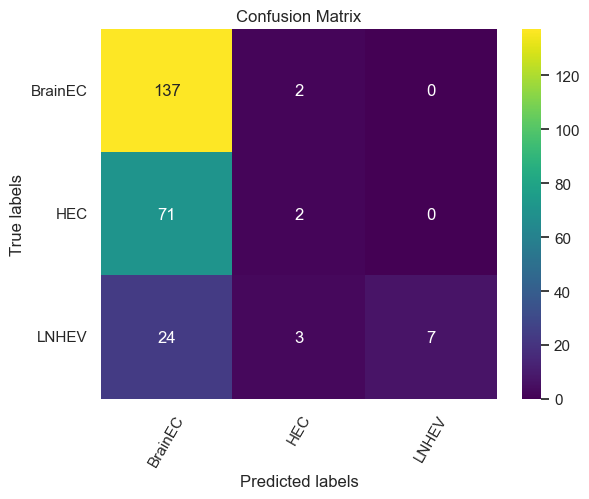

In [390]:
cm = confusion_matrix(y_test, predicted_labels)

# Plot confusion matrix
ax = sns.heatmap(cm, annot=True, fmt="d", cmap="viridis")
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(pred_label, rotation=60); 
ax.yaxis.set_ticklabels(true_label, rotation=0);

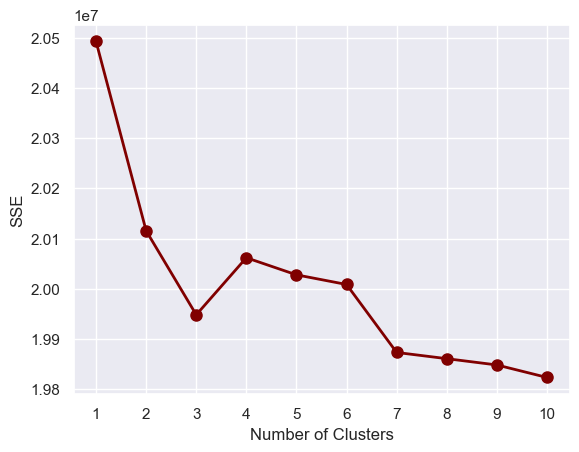

In [400]:
#Initialize kmeans parameters
kmeans_param = {"init": "random",
               "n_init": 10,
               "random_state":1}
#create list to hold SSE values for each k
sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, **kmeans_param)
    kmeans.fit(x)
    sse.append(kmeans.inertia_)

#visualize results
plt.plot(range(1, 11), sse, color='maroon', marker='o', linewidth=2, markersize=8)
plt.xticks(range(1, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

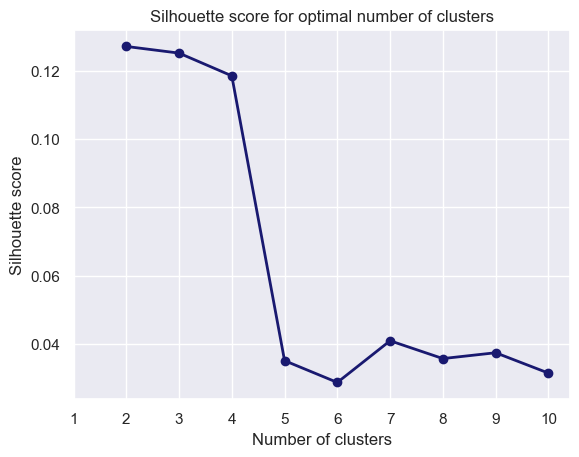

In [399]:
##Silhouette score
silhouette_score_values = []
n_clusters = range(2,11)

for i in n_clusters:
    classifier = KMeans(i)
    classifier.fit(x)
    k_labels=classifier.predict(x)
    silhouette_score_values.append(silhouette_score(x,k_labels , metric='euclidean'))

plt.plot(n_clusters, silhouette_score_values, color = 'midnightblue', marker='o', linewidth=2, markersize=6)
plt.title('Silhouette score for optimal number of clusters')
plt.xlabel('Number of clusters')
plt.xticks(range(1,11))
plt.ylabel('Silhouette score')
plt.show()

In [318]:
for n in range(len(silhouette_score_values)):
    print("Silhouette score for",n, "clusters is: ", silhouette_score_values[n])

Silhouette score for 0 clusters is:  0.24228590939077294
Silhouette score for 1 clusters is:  0.11151380134611971
Silhouette score for 2 clusters is:  0.111400354039837
Silhouette score for 3 clusters is:  0.028285767178937823
Silhouette score for 4 clusters is:  -0.07203551492825243
Silhouette score for 5 clusters is:  0.05396675605355593
Silhouette score for 6 clusters is:  -0.10904905180705278
Silhouette score for 7 clusters is:  0.03511664754327884
Silhouette score for 8 clusters is:  0.053045892602627674


The explained variance ratio of PCA with 2 components is:  [0.03104084 0.00978471]
The explained variance ratio of PCA cumulative is:  [0.03104084 0.04082555]


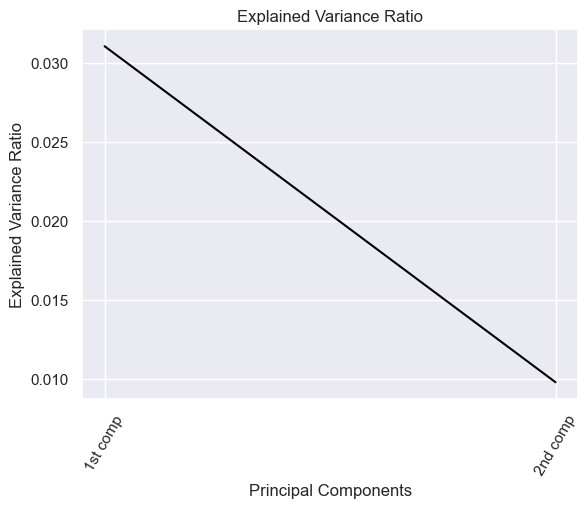

,principal component 1,principal component 2
0,-1.923347,3.799360
1,-2.937113,-1.445688
2,-17.473476,-2.858226
3,-0.029362,-0.785374
4,7.700222,0.480896


In [319]:
#PCA with 2 dims
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)
print("The explained variance ratio of PCA with 2 components is: ", pca.explained_variance_ratio_)
print("The explained variance ratio of PCA cumulative is: ", pca.explained_variance_ratio_.cumsum())
###Low explained variance ratio indicating that the data is uncorrelated and there's noting gained by doing PCA
plt.plot(range(0,2), pca.explained_variance_ratio_ , color='black')
plt.xlabel('Principal Components')
plt.ylabel('Explained Variance Ratio')
plt.xticks(range(0,2), ["1st comp", "2nd comp"], rotation=60)
plt.title('Explained Variance Ratio')
plt.show()

x_pca = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])
x_pca.head()

In [320]:
#Encode the labels 
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(labels)
print(len(y))
print(label_encoder.classes_)
unique_labels = np.unique(labels)
print(len(unique_labels))

1233
['BrainEC' 'HEC' 'LNHEV']
3


In [401]:
##clustering for k=2
kmeans_2 = KMeans(init="random", n_clusters=2, n_init=10, random_state=108)
kmeans_2.fit(x)

sil = silhouette_score(x,kmeans_2.labels_ , metric='euclidean')
print("Silhouette score for 2 clusters is: ", sil)

print("Inertia for 2 clusters is: ", round(kmeans_2.inertia_, 3))

#Create a mapping dictionary for kmeans labels and assign the clusters respectively
mapping_dic = {0:'BrainEC', 1:'HEC', 2:'LNHEV'}
kmeans_pred = [mapping_dic[i] for i in kmeans_3.labels_]

print(len(kmeans_pred))

Silhouette score for 2 clusters is:  0.12642985382273247
Inertia for 2 clusters is:  20116566.97
1233


In [397]:
kmeans_accu = accuracy_score(y, kmeans_2.labels_)*100
print("The accuracy of Kmeans clustering is: {:.2f}%".format(kmeans_accu))

The accuracy of Kmeans clustering is: 45.26%


['HEC', 'BrainEC']


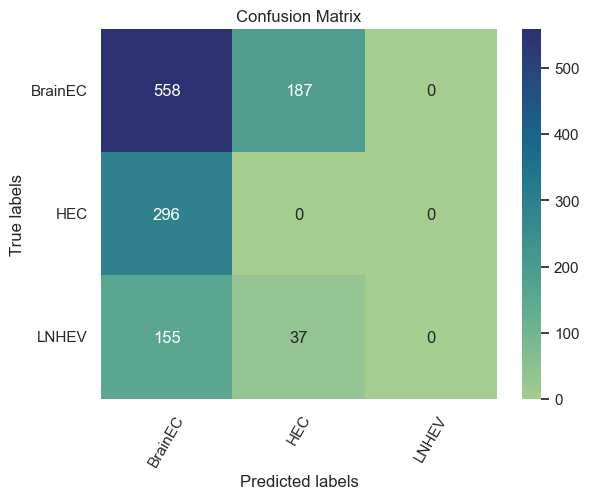

In [392]:
predk_label = list(set((kmeans_pred)))
print(predk_label)
predk_label.append('LNHEV')
predk_label.sort()

# Compute confusion matrix
cm = confusion_matrix(y, kmeans_2.labels_)

# Plot confusion matrix
ax = sns.heatmap(cm, annot=True, fmt="d", cmap="crest")
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(predk_label, rotation=60); 
ax.yaxis.set_ticklabels(unique_labels, rotation=0);